<h2>
<center>Unsupervised Pairs Selection:</center>
<center>Applying PCA and OPTICS clustering to stock prices</center>
</h2>

<h3>
<center>Franklin Williams</center>
</h3>


<center>streater@uw.edu</center>
<center><a href="https://www.linkedin.com/in/fswilliams/"> LinkedIn </a></center>



## Introduction
Pairs trading is a strategy used by many financial institutions. Within this strategy, fund managers attempt to construct a mean-reverting prices series of pairs of securities. As the prices series reverts to its long-term mean, the fund manager closes or opens positions accordingly to profit. As more financial securities are traded, the universe of potential pairs continues to balloon in size. This increase in size leads to more instances of spurious correlations among financial securities. To constrain the search universe and avoid spurious correlations, Sarmento and Horta outline an unsupervised clustering approach to find securities for pairs trading in their work: <a href="https://www.springer.com/gp/book/9783030472504#aboutBook"> “A Machine Learning based Pairs Trading Investment Strategy.”</a> [1].

Following the work of Sarmento and Horta, this notebook is dividend into three states: dimensionality reduction via principal component analysis, unsupervised clustering via OPTICS, and pairs selection via author proposed criteria. Finally, it concludes with an application of optimal entry and liquidation levels of portfolios composed of selected pairs and closing remarks.

## Body

### State 0: Data collection

Daily closing prices from 600 publicly traded U.S. securities were sampled for this notebook. Data ranges from 2010-01-04 through 2020-10-11. Data from 2019-01-01 through 2020-10-11 is held out for testing.

In [1]:
from mlpairs import OpticsPairs
import pandas as pd

stock_prices = pd.read_csv('sample_US_equity_close.csv',
                           index_col=0,
                           parse_dates=True)
train = stock_prices[:'2018']
test = stock_prices['2019':]

train.head()

,UVSP,CBSH,MMLP,LOGN,MTSL,CRDF,THYCY,CUB,CZNC,OPNT,...,TITN,CHMG,JLL,PARF,GPN,GURE,BCE,ROCK,NM,DVAX
date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,17.75,26.586,31.990,12.4,4.26,328.319,2.828,39.15,9.65,120.0,...,12.30,21.4,61.53,18.0,26.335,68.50,27.86,16.80,63.8,14.400
2010-01-05,16.86,26.539,32.370,12.4,4.74,323.999,2.828,41.58,9.55,120.0,...,12.72,21.4,63.04,18.0,26.280,68.25,27.65,17.76,67.0,15.600
2010-01-06,16.78,26.437,32.720,12.4,4.80,319.679,2.828,41.02,9.27,120.0,...,12.83,20.4,63.44,18.0,26.185,69.25,27.68,17.42,67.1,15.899
2010-01-07,17.12,27.060,32.950,12.4,4.80,323.999,2.828,40.26,9.03,120.0,...,12.88,20.4,63.67,18.0,26.020,67.75,26.89,17.42,67.3,15.400
2010-01-08,17.17,26.722,32.839,12.4,5.10,323.999,2.828,40.76,9.23,120.0,...,13.02,20.4,63.83,18.0,24.485,72.45,27.02,18.17,69.0,15.400


### State 1: Dimensionality Reduction  
### Calculate return series

In [2]:
op = OpticsPairs(train)
op.returns.head()

,UVSP,CBSH,MMLP,LOGN,MTSL,CRDF,THYCY,CUB,CZNC,OPNT,...,TITN,CHMG,JLL,PARF,GPN,GURE,BCE,ROCK,NM,DVAX
date,,,,,,,,,,,,,,,,,,,,,
2010-01-05,-0.050141,-0.001768,0.011879,0.0,0.112676,-0.013158,0.0,0.062069,-0.010363,0.0,...,0.034146,0.000000,0.024541,0.0,-0.002088,-0.003650,-0.007538,0.057143,0.050157,0.083333
2010-01-06,-0.004745,-0.003843,0.010812,0.0,0.012658,-0.013333,0.0,-0.013468,-0.029319,0.0,...,0.008648,-0.046729,0.006345,0.0,-0.003615,0.014652,0.001085,-0.019144,0.001493,0.019167
2010-01-07,0.020262,0.023565,0.007029,0.0,0.000000,0.013514,0.0,-0.018528,-0.025890,0.0,...,0.003897,0.000000,0.003625,0.0,-0.006301,-0.021661,-0.028540,0.000000,0.002981,-0.031386
2010-01-08,0.002921,-0.012491,-0.003369,0.0,0.062500,0.000000,0.0,0.012419,0.022148,0.0,...,0.010870,0.000000,0.002513,0.0,-0.058993,0.069373,0.004835,0.043054,0.025260,0.000000
2010-01-11,-0.019220,0.006324,0.009775,0.0,-0.011765,0.000000,0.0,0.030667,-0.028169,0.0,...,0.004608,0.000000,-0.015353,0.0,-0.023484,0.017253,-0.008882,-0.040726,0.023188,0.032468


### Apply PCA

Principal component analysis is applied to the scaled return series. The below graphs plot the loadings on of each security on the first five principal components. It is unsurprising that nearly every security has a similar loading on the first principal component. This component is generally interpreted as the “market” component of financial instruments which explains much of the variation in price movements across securities. Because our sample data consist of publicly traded U.S. equity listings, we expect to see the presence of this first principal component.

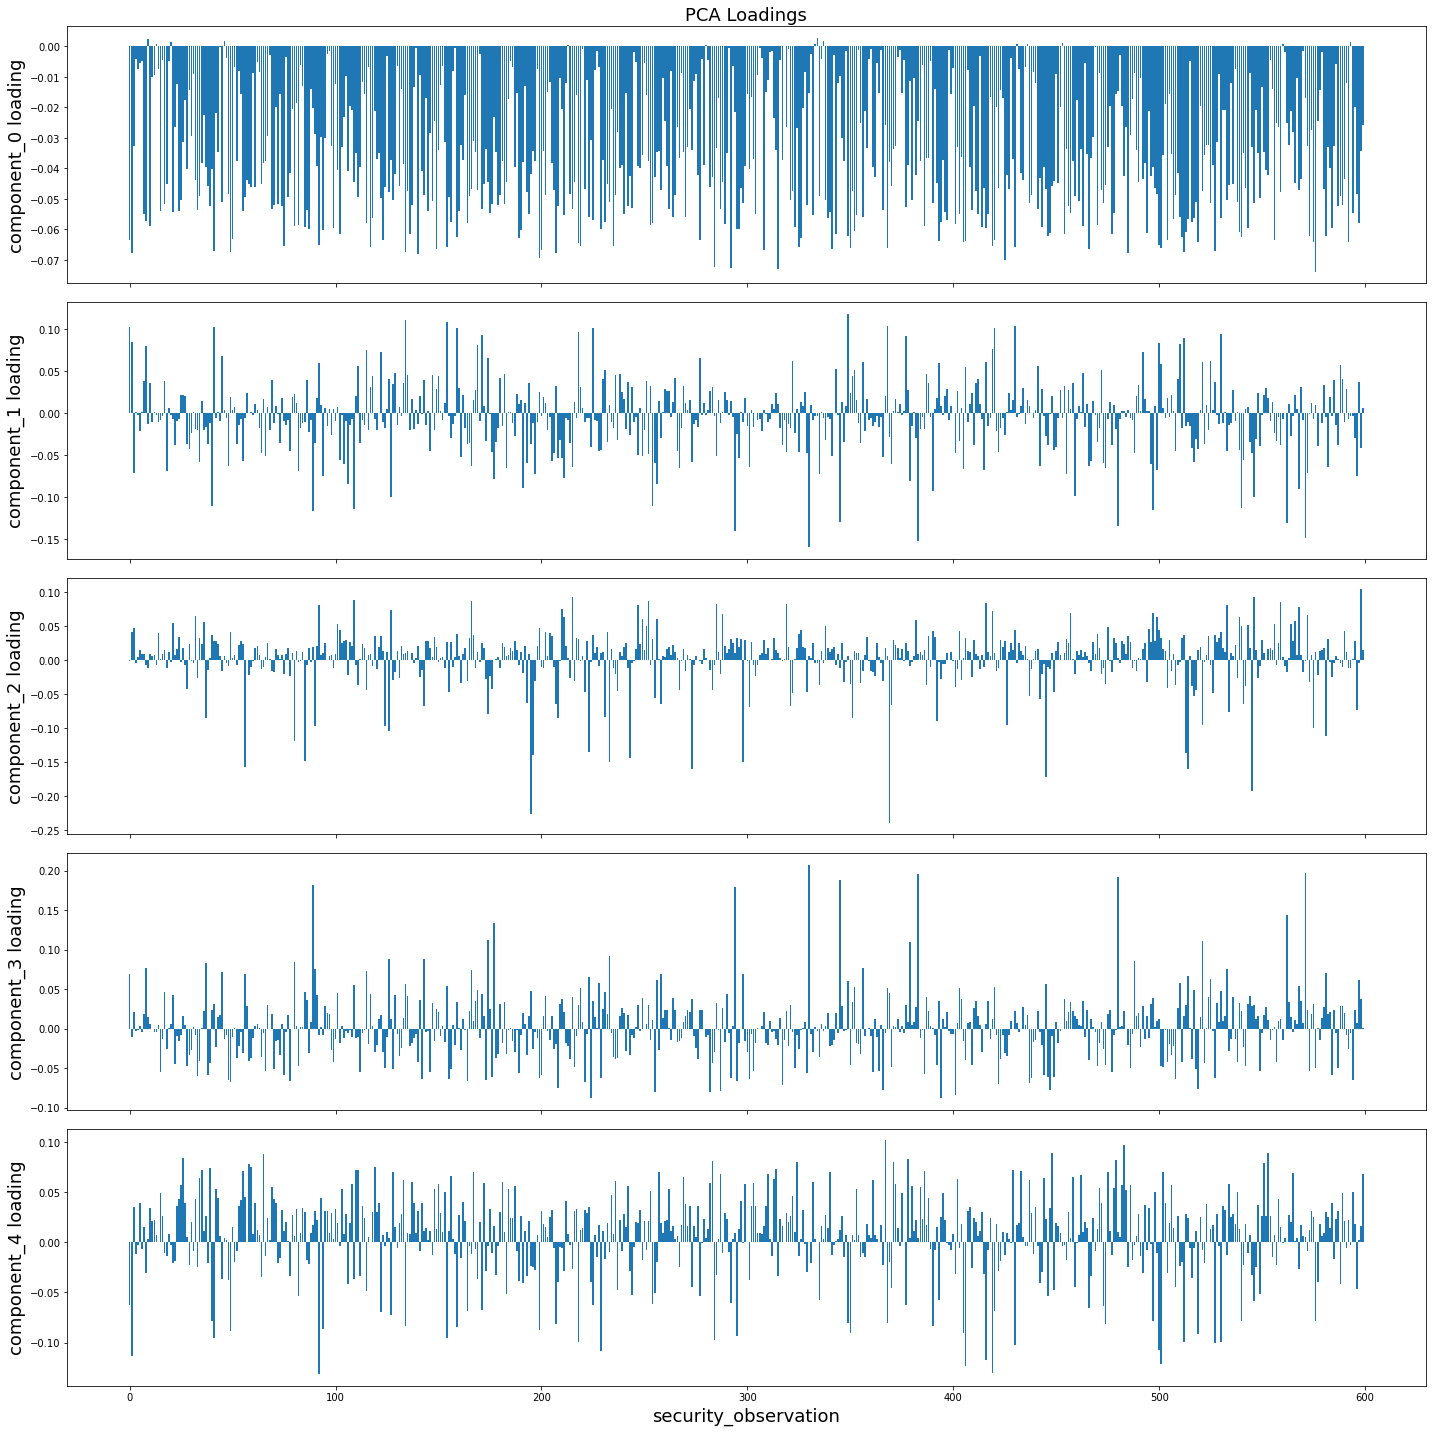

In [3]:
op.reduce_PCA()
op.plot_loadings()

Implementing PCA reduced the dimensions of our data from 2264x600 to 10x600. Below we chart the cumulative variance explained by the 10 dimensions in component space. We see the “market” component explains roughly 20% of the variance in price movements.


Total variance explained: 28.470000000000002%


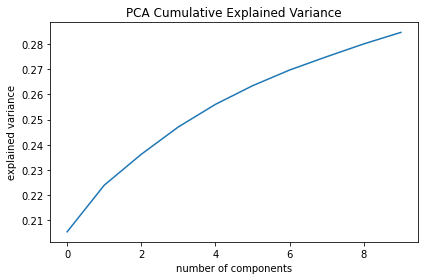

In [12]:
import numpy as np 
op.plot_explained_variance()
total_variance_explained = np.cumsum(op.explained_variance_ratio_)[-1]
print(f"Total variance explained: {round(total_variance_explained, 4)*100}%")

## State 2: Unsupervised Learning
### Apply OPTICS


Unlike other clustering algorithms, OPTICS computes an augmented cluster-ordering of the data rather than clustering the data explicitly. This frees the algorithm from relying on global parameters that might be heavily influenced by one cluster, but not accurately describe other clusters. Ankerst et. al state, “It is a versatile basis for both automatic and interactive
cluster analysis” [2]. 

The OPTICS algorithm identified 323 potential pairs of securities that share a common label generated from unsupervised learning.


In [5]:
# Generate clusters and find potential trading pairs
op.find_pairs()
op.pairs

Found 323 potential pairs


0       (INDB, PFS)
1      (INDB, WSBC)
2       (INDB, STL)
3       (INDB, FCF)
4      (INDB, ABCB)
           ...     
318      (EXC, WEC)
319      (EXC, PPL)
320      (BKH, WEC)
321      (BKH, PPL)
322      (WEC, PPL)
Length: 323, dtype: object

To visually inspect the clusters, we plot the loadings of the first two and first three principal components from each security. We can clearly see one cluster of securities that stands out from the rest in the upper left of the 2-dimensional graph. Additionally, when adding a third principal component, we can more easily see other clusters group together along the z-axis.

The light points share a common label indicate data points considered noise and are excluded and the corresponding securities are excluded from the potential pairs list. 


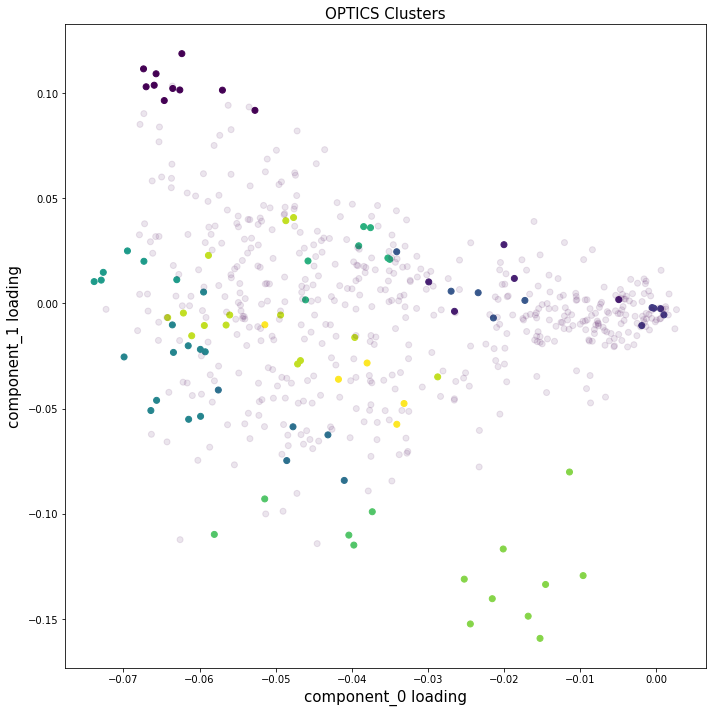

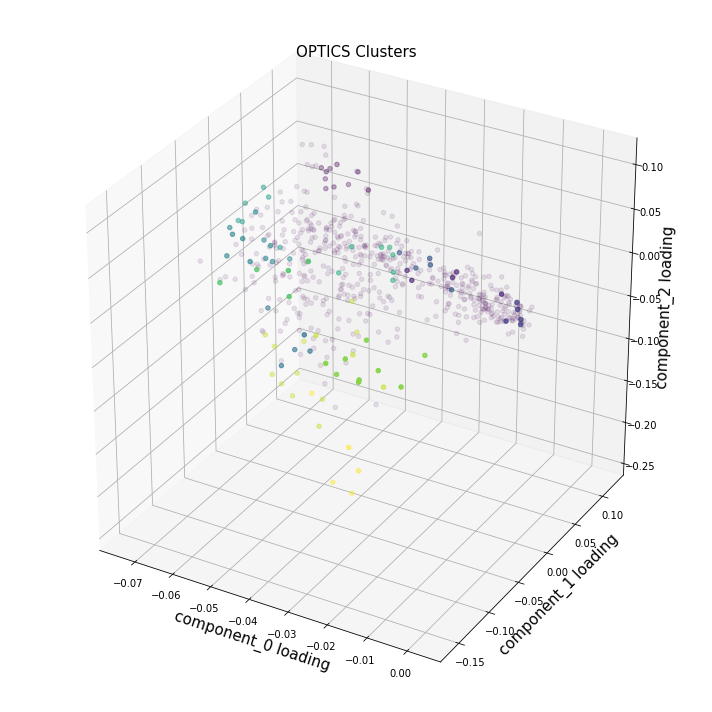

In [7]:
# Plot clusters found
op.plot_clusters(n_dimensions=2)
op.plot_clusters(n_dimensions=3)

## State 3: Select Pairs
### Apply Critera

Sarmento and Horta suggest four criteria to further filter the potential pairs to increase the probability of selecting pairs of securities whose prices will continue to mean revert in the future. 
* Statistically significant t-stat from the Engle-Granger test (5% level)
* Hurst exponent < 0.5  
* Half-life between [1, 252]   
* Spread must cross the mean on average 12x per year  

These four criteria indicate positive characteristics for potential pairs of securities. The Engle-Granger tests the pair for cointegration. A Hurst exponent below 0.5 indicates that the pair of prices regresses strongly to the mean. Pairs with extreme half-life values, below 1 or above 252, are excluded from the selected pairs. Extreme half-life values indicate a price series that either reverts too quickly or too slowly to be traded. Finally, the price series must cross the long-term spread mean on average 12 times a year. This enforces one trade on average, per month.

After filtering potential pairs, we find 7 pairs of securities that meet all four criteria. We plot the prices individual prices series and the beta-adjusted spread for each pair below.


In [8]:
# Calculate potential pair statistics
op.calc_eg_norm_spreads()
op.calc_hurst_exponents()
op.calc_half_lives()
op.calc_avg_cross_count()

In [9]:
# Filter potential pairs
op.filter_pairs()
op.filtered_pairs

Found 7 tradable pairs!


,pair,pvalue,hurst_exp,half_life,avg_cross_count
0,"(INDB, PFS)",0.046144,0.447497,80.930131,15.805654
12,"(PFS, ABCB)",0.013735,0.416778,42.699897,12.577739
14,"(PFS, SRCE)",0.024965,0.464559,66.670795,12.355124
31,"(FCF, CTBI)",0.016416,0.326524,49.896382,18.254417
81,"(FMX, BCE)",0.013489,0.400647,54.692031,13.579505
137,"(DD, PH)",0.026890,0.406692,59.828738,14.581272
259,"(ARE, IRET)",0.001903,0.389642,35.305126,12.911661


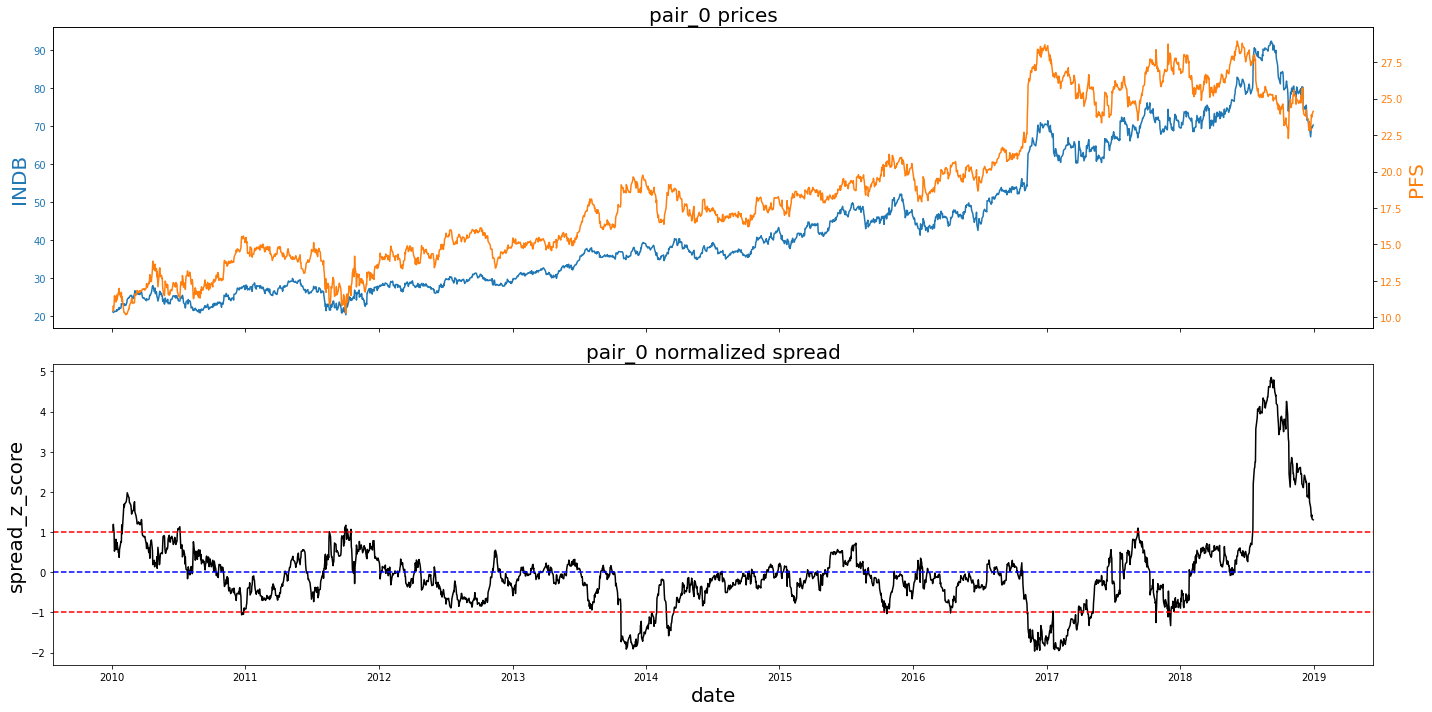

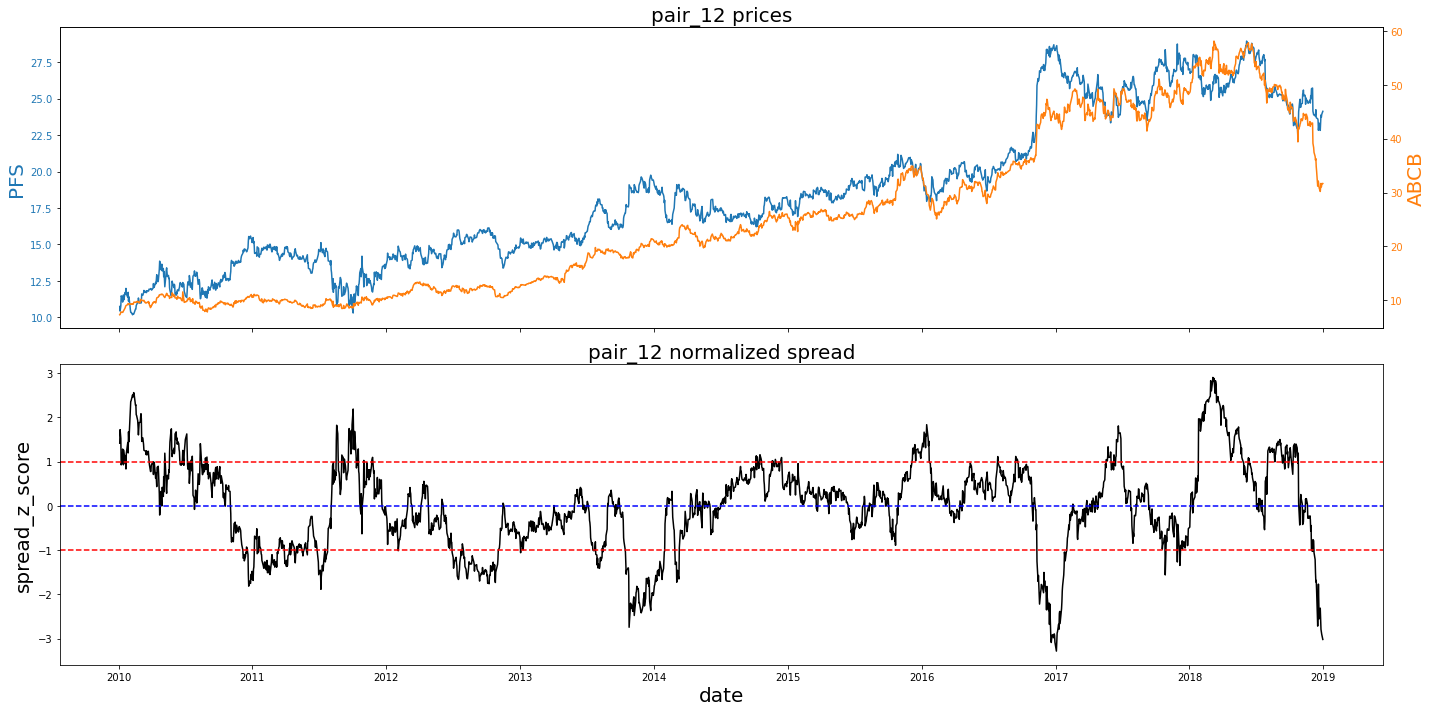

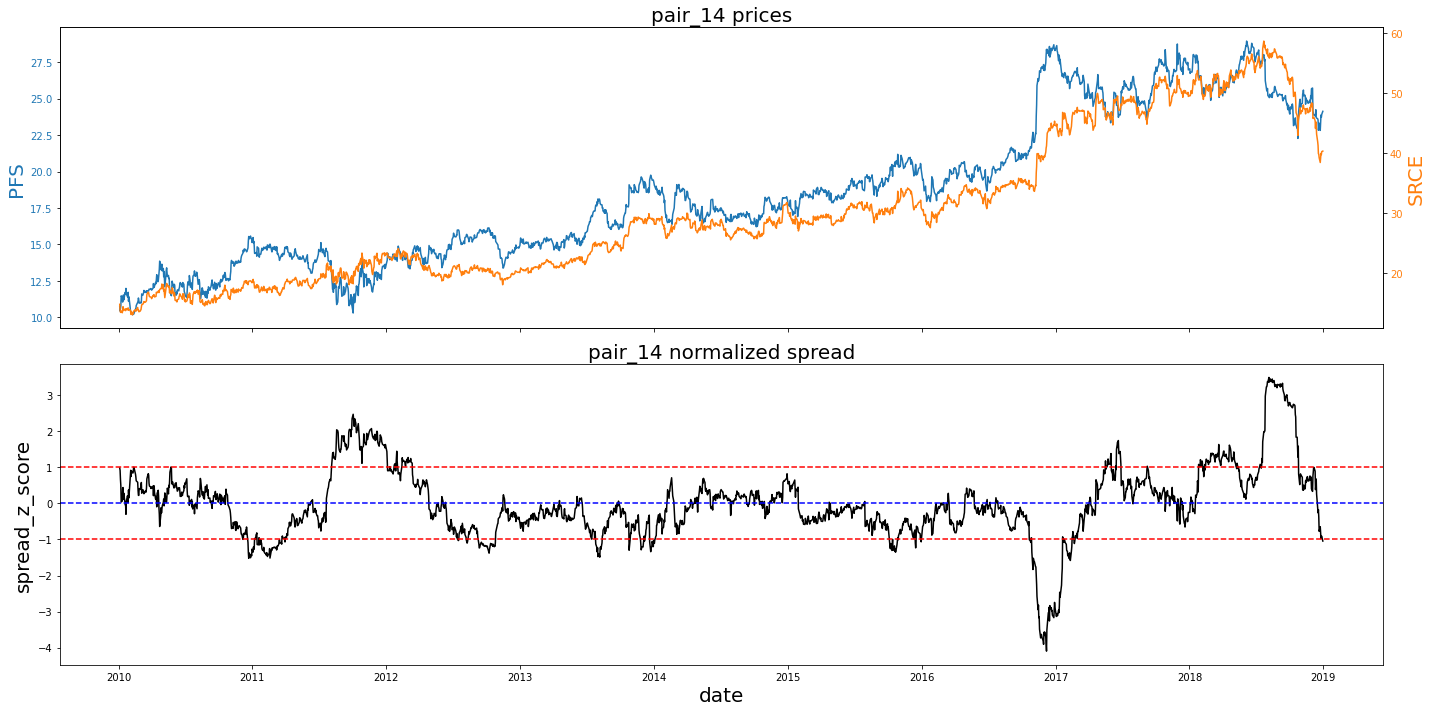

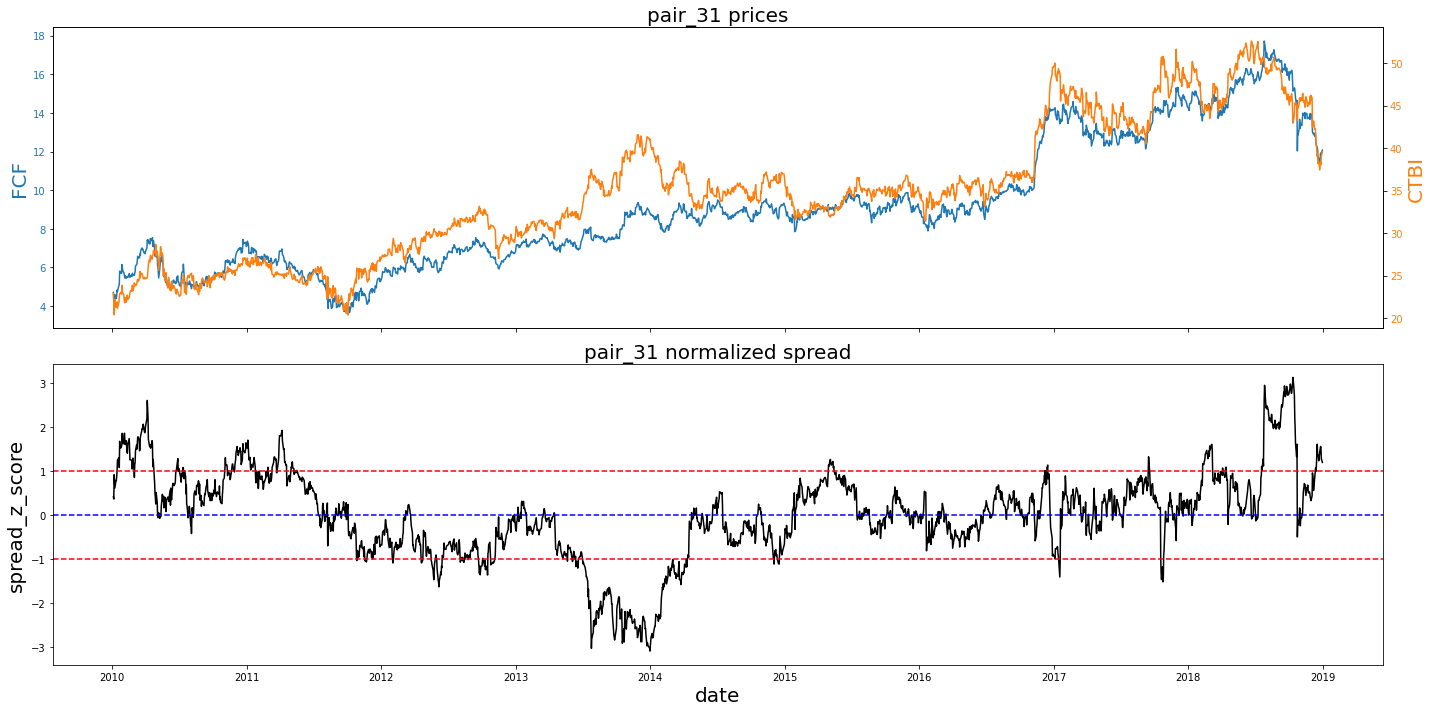

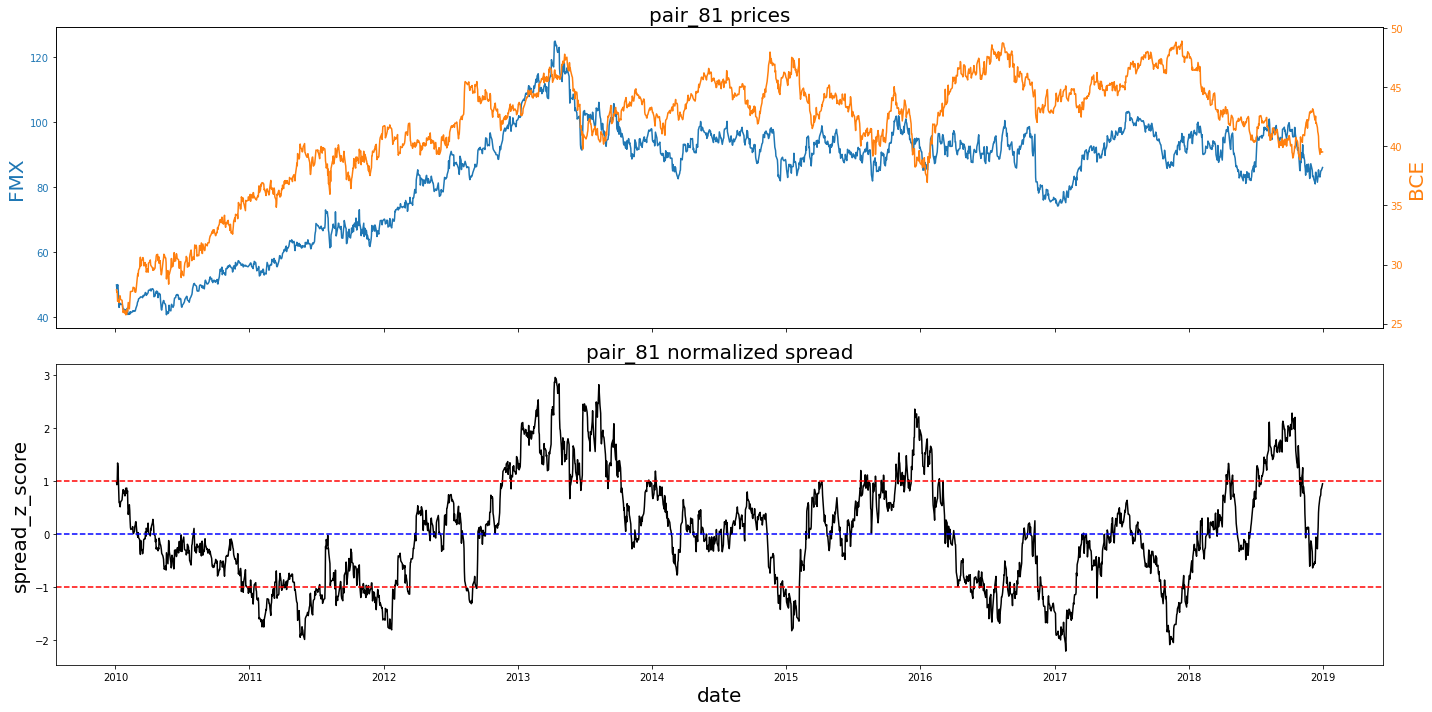

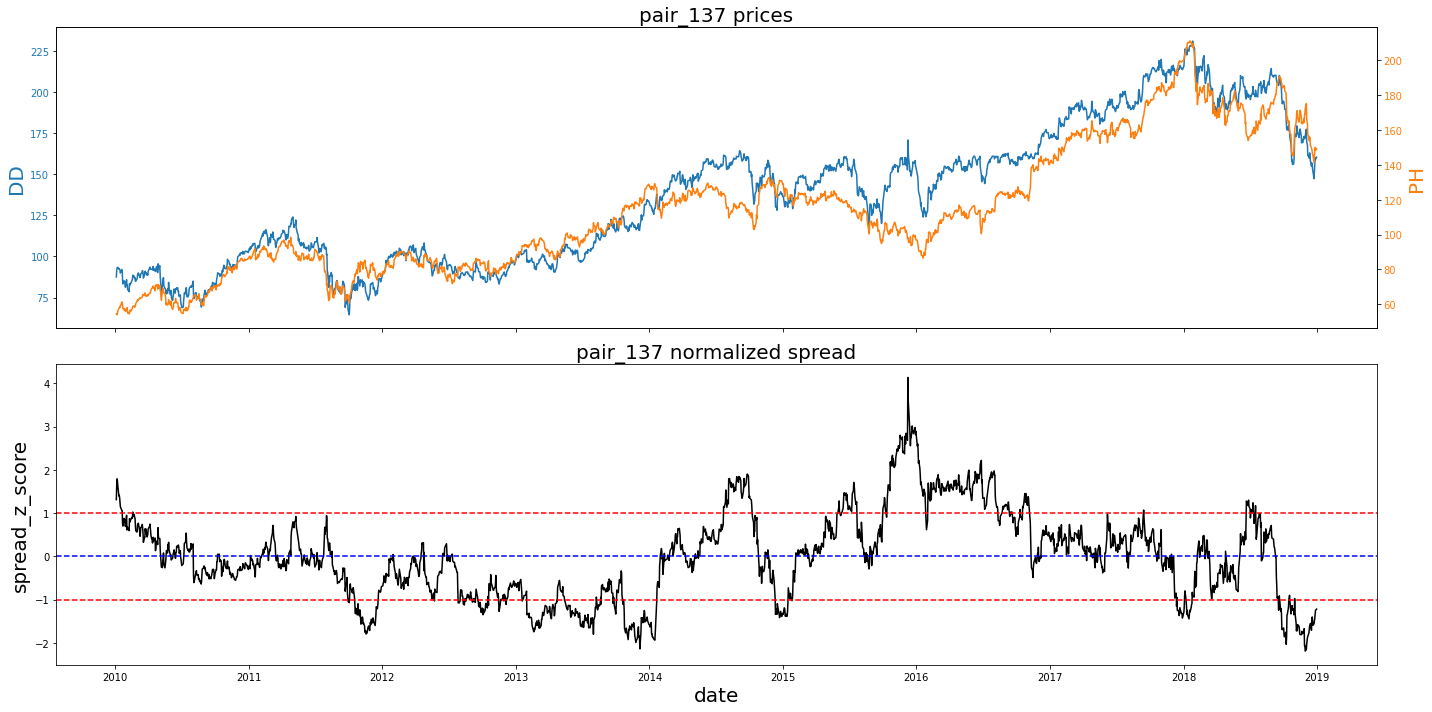

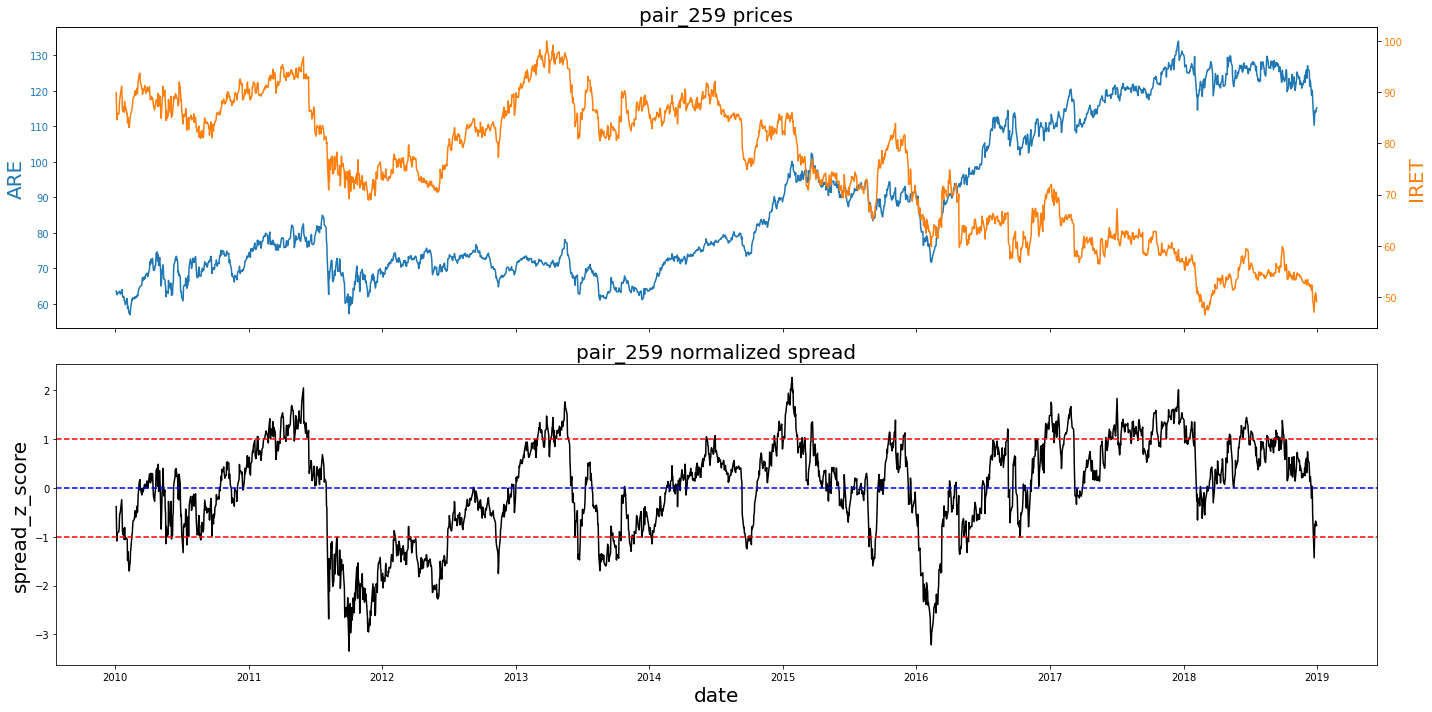

In [10]:
for i in op.filtered_pairs.index:
    op.plot_pair_price_spread(idx=i)

## Application
### Optimal Entry and Liquidation Levels

From our training data, seven pairs of securities were eligible to conduct a pairs trading strategy. As an example, we now find the optimal entry and liquidation levels of the pairs based on the Ornstein-Uhlenbeck model as proposed by Leung and Li: “Optimal Mean reversion Trading: Mathematical Analysis and Practical Applications” [3]. 

Parameters are estimated for the models from the training data. We see that the models fit the empirical data well, based on the comparable max log-likelihood statistics. 

Under these models, we see that four pairs reach the optimal entry level in the test data.


Model parameters: ['INDB', 'PFS'] 
               Theta        Mu     Sigma  Max log-likelihood
empirical  0.870596  0.242420  0.379624            2.314830
simulated  1.105098  1.616707  0.383000            2.315412 

Model parameters: ['PFS', 'ABCB'] 
               Theta        Mu     Sigma  Max log-likelihood
empirical  0.895983  3.691417  0.316737            2.502767
simulated  0.878859  4.706494  0.320009            2.494543 

Model parameters: ['PFS', 'SRCE'] 
               Theta        Mu     Sigma  Max log-likelihood
empirical  0.599918  2.804014  0.272679            2.650790
simulated  0.611929  3.742083  0.276661            2.645131 

Model parameters: ['FCF', 'CTBI'] 
               Theta        Mu     Sigma  Max log-likelihood
empirical  0.563974  0.594142  0.410110            2.238283
simulated  1.085396  2.346316  0.409466            2.239728 

Model parameters: ['FMX', 'BCE'] 
               Theta        Mu     Sigma  Max log-likelihood
empirical  0.665840  1.301177  0.

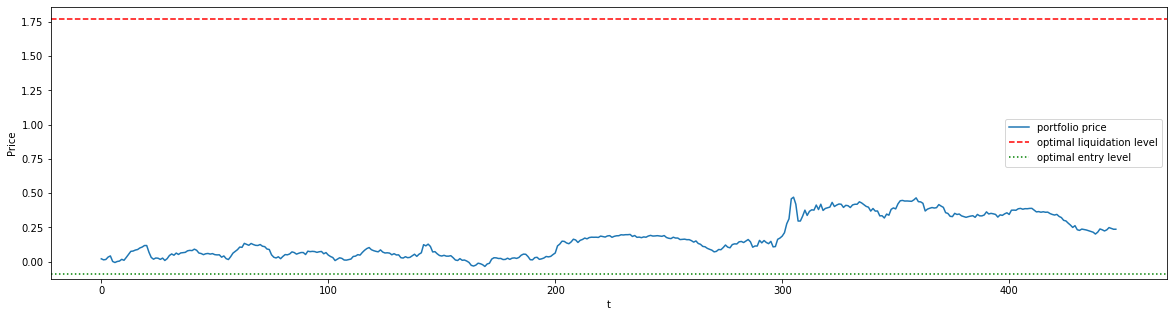

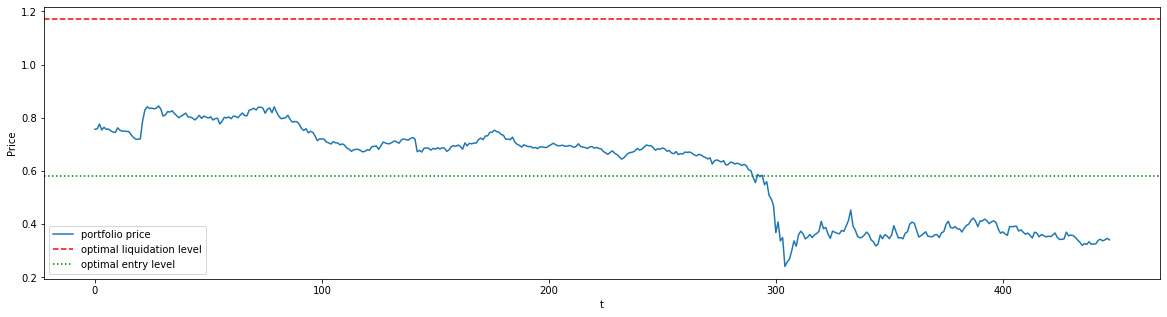

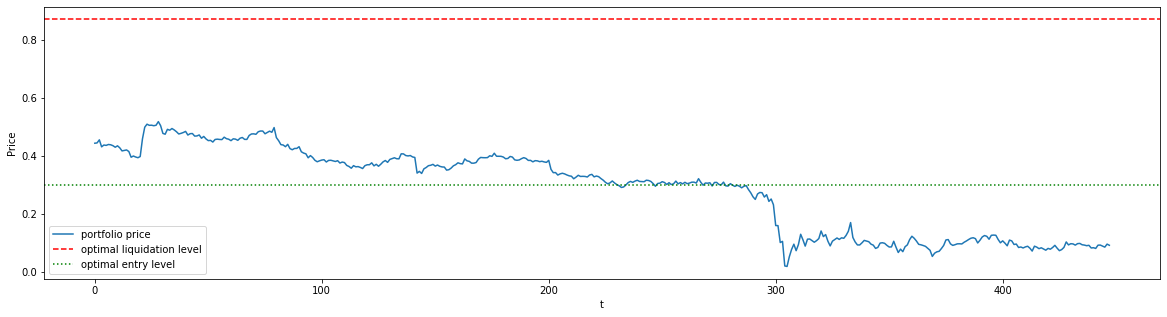

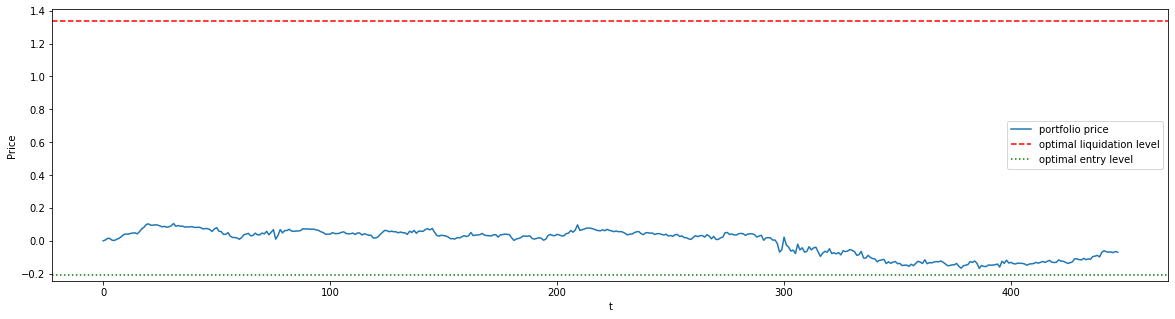

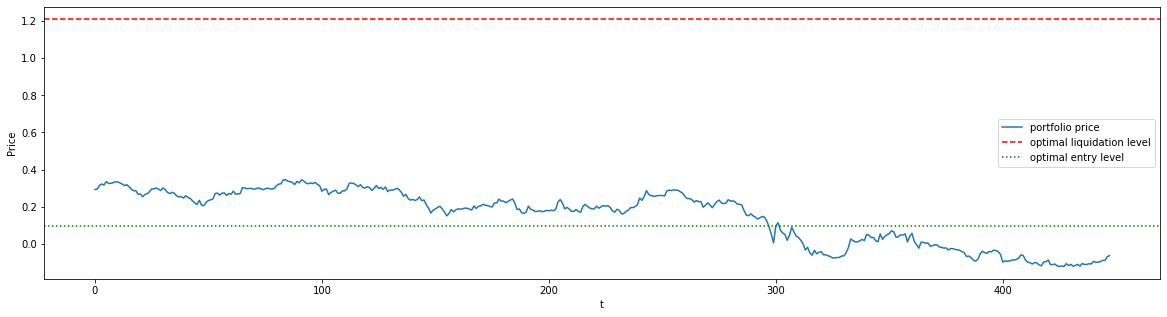

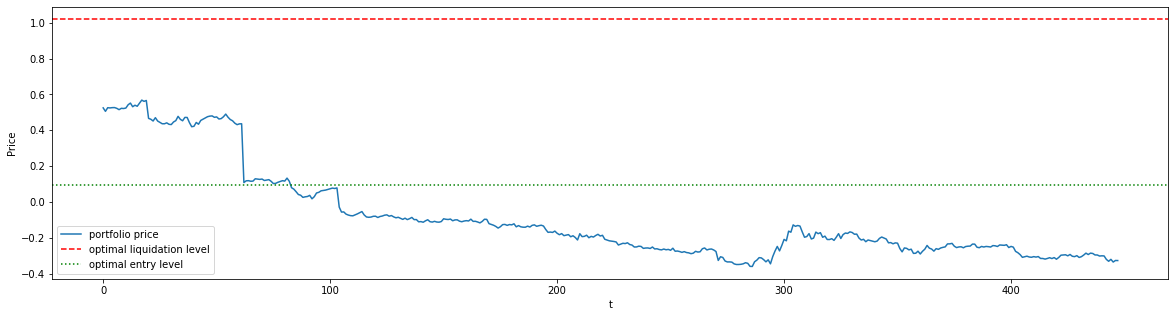

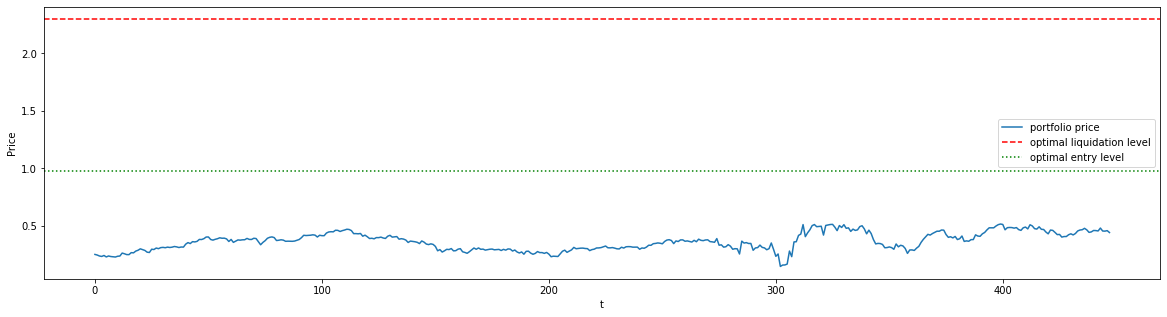

In [13]:
from mlfinlab.optimal_mean_reversion import OrnsteinUhlenbeck

# Loop through first 5 tradable pairs
for i in range(7):
    trading_pair = list(op.filtered_pairs['pair'].iloc[i])
    
    # Initialize
    ou = OrnsteinUhlenbeck()
    
    # Fit to training data
    ou.fit(train[trading_pair],
           data_frequency='D',
           discount_rate=[0.01, 0.01],
           transaction_cost=[0.02, 0.02],
           stop_loss=None)
    
    print(f'Model parameters: {trading_pair}', '\n', ou.check_fit(), '\n')
    
    # Plot liquidation and entry levels of test data
    fig = ou.plot_levels(test[trading_pair],
                         stop_loss=False)
    fig.set_figheight(5)
    fig.set_figwidth(20)

## Conclusion


This notebook demonstrates an empirical example of the pairs selection process outlined in [1] to efficiently reduce the search space and select quality trading pairs. Roughly 9 years of daily stock price data for 600 securities were reduced to 10 dimensions through principal component analysis. Next, over 300 potential trading pairs were identified through OPTICS clustering. Seven pairs from the clusters met the four selection criteria. Finally, optimal entry and liquidation levels were estimated from training data and verified with testing data.


### Works Cited:
[1] Sarmento, Simão, and Nuno Horta. “A Machine Learning Based Pairs Trading Investment Strategy: Simão Sarmento.” Springer, Springer International Publishing, 2020, www.springer.com/gp/book/9783030472504.  

[2] M. Ankerst, M. M. Breunig, H.-P. Kriegel, and J. Sander, “Optics: ordering points to identify the clustering structure,” in ACM Sigmod record, vol. 28, no. 2. ACM, 1999, pp. 49–60.

[3] Leung, Tim, and Xin Li. “Optimal Mean Reversion Trading: Mathematical Analysis and Practical Applications.” Amazon, World Scientific Publishing Company, 2451, www.amazon.com/Optimal-Mean-Reversion-Trading-Mathematical/dp/9814725919. 
